In [1]:
import pandas as pd
import re
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
import torch

/Users/christopherjohnson/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def print_mem():
    alloc = torch.mps.current_allocated_memory()/10**9
    print('Allocated:',alloc,alloc/9)

In [4]:
def fix_columns(df):
    cols = []
    for col in df.columns:
        cols.append(col.replace(' ',''))
    df.columns = cols
    return df

In [5]:
fda_insp_df = pd.read_excel("inspection_details.xlsx")
fda_cit_df = pd.read_excel("citation_details.xlsx")

In [6]:
fda_insp_df = fix_columns(fda_insp_df)
fda_cit_df = fix_columns(fda_cit_df)

In [7]:
fda_cit_df = fda_cit_df[fda_cit_df.ProgramArea == 'Drugs']

In [8]:
long_df = fda_cit_df.groupby('InspectionID')['ShortDescription'].sum().reset_index()
long_df['ShortDescription'] = long_df['ShortDescription'].apply(lambda x: x.replace('.','. ')[:-1])

In [9]:
long_df = long_df.merge(fda_insp_df[['InspectionID','Classification','FiscalYear']].drop_duplicates()
              ,how='left'
              ,on='InspectionID')

In [10]:
long_df = long_df[long_df.FiscalYear >=2017].drop('FiscalYear',axis=1)

In [11]:
insp_dups = long_df['InspectionID'].value_counts().reset_index()
insp_dups.columns = ['InspectionID','Num']
insp_ids = list(insp_dups[insp_dups.Num == 1]['InspectionID'].unique())

In [12]:
long_un_df = long_df[long_df['InspectionID'].isin(insp_ids)]

In [13]:
long_un_df['Classification'] = long_un_df['Classification'].apply(lambda x: re.findall(r'\((.*?)\)', x)[0])

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_92504/2799569883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_un_df['Classification'] = long_un_df['Classification'].apply(lambda x: re.findall(r'\((.*?)\)', x)[0])


<Axes: xlabel='Classification'>

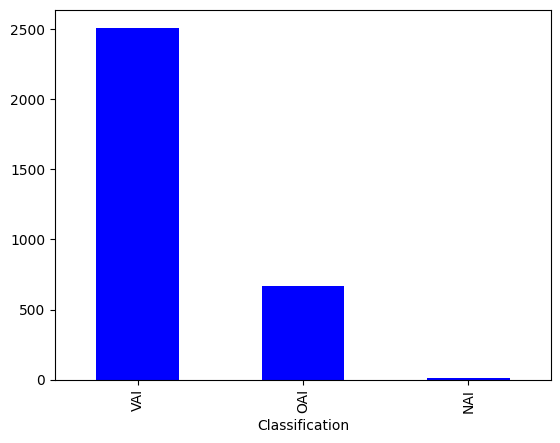

In [14]:
long_un_df['Classification'].value_counts().plot(kind='bar',color='blue')

In [15]:
print_mem()

Allocated: 0.0 0.0


In [16]:
model_ckpt = 'distilbert-base-uncased'
#model_ckpt = 'microsoft/phi-1'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [17]:
print_mem()

Allocated: 0.0 0.0


In [18]:
long_un_df['ShortDescription'] = long_un_df['ShortDescription'].astype('string')

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_92504/1474196583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_un_df['ShortDescription'] = long_un_df['ShortDescription'].astype('string')


In [19]:
long_un_df['Classification'] = long_un_df['Classification'].apply(lambda x: 1 if x == 'OAI' else 0)

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_92504/3079299961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_un_df['Classification'] = long_un_df['Classification'].apply(lambda x: 1 if x == 'OAI' else 0)


In [20]:
oais_list = list(long_un_df[long_un_df.Classification == 1]['InspectionID'])
num_oais = len(oais_list)
non_oais_list = list(long_un_df[long_un_df.Classification == 0].sample(n = 1*num_oais, random_state=1)["InspectionID"])
long_un_sample_df = long_un_df[long_un_df['InspectionID'].isin(non_oais_list+oais_list)]

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
input_df = long_un_sample_df[['ShortDescription','Classification']]
input_df.columns = ['text','label']

In [23]:
train, test = train_test_split(input_df,test_size=0.2,random_state=10)
len(train),len(test)

(1068, 268)

In [24]:
train, val = train_test_split(train,test_size=0.2,random_state=42)

In [25]:
datadict = DatasetDict({"train": Dataset.from_pandas(train), 
                        "validation": Dataset.from_pandas(val),
                        "test": Dataset.from_pandas(test)})

In [26]:
datadict

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 854
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 214
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 268
    })
})

In [27]:
def tokenize_function(ex):
    return tokenizer(ex['text'], truncation=True,padding=True)

In [28]:
tokenized_dataset = datadict.map(tokenize_function,batched=False)

Map:   0%|          | 0/854 [00:00<?, ? examples/s]

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Map:   0%|          | 0/268 [00:00<?, ? examples/s]

In [29]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 854
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 214
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 268
    })
})

In [30]:
from transformers import AutoModelForSequenceClassification
import torch

In [31]:
device = "mps"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt,num_labels =2)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
print_mem()

Allocated: 0.267824384 0.029758264888888893


In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels,preds)
    prec = precision_score(labels,preds)
    rec = recall_score(labels,preds)
    return {"Accuracy":acc, "F1":f1, "Precision":prec, "Recall": rec}

In [35]:
from transformers import Trainer, TrainingArguments

In [36]:
batch_size = 2
logging_steps = len(tokenized_dataset['train']) // batch_size
model_name = f"{model_ckpt}-finetuned"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 5,
                                  learning_rate = 1e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps = logging_steps,
                                  push_to_hub=False,
                                  log_level='error')

/Users/christopherjohnson/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
print(torch.mps.current_allocated_memory()/10**9)
print(torch.mps.driver_allocated_memory()/10**9)

0.267824384
1.09092864


In [38]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['validation'],
                  tokenizer=tokenizer)
trainer.train()

  0%|          | 0/2135 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 2.04 GB, other allocations: 6.94 GB, max allowed: 9.07 GB). Tried to allocate 89.42 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [38]:
print_mem()

Allocated: 1.144068096 0.12711867733333335
